## 1. Download Files and Setup (Takes very long time to run)

### Get Dataset and Model Files

In [2]:
!pip install gdown
!gdown 1FTDvjIhIwhyH8xz4LPdrKcl1XP59SoNW

Access denied with the following error:



 	Too many users have viewed or downloaded this file recently. Please
	try accessing the file again later. If the file you are trying to
	access is particularly large or is shared with many people, it may
	take up to 24 hours to be able to view or download the file. If you
	still can't access a file after 24 hours, contact your domain
	administrator. 

You may still be able to access the file from the browser:

	 https://drive.google.com/uc?id=1FTDvjIhIwhyH8xz4LPdrKcl1XP59SoNW 



In [2]:
!unzip hubmap-kidney-segmentation.zip -d kidney_dataset

Archive:  hubmap-kidney-segmentation.zip
  inflating: kidney_dataset/HuBMAP-20-dataset_information.csv  
  inflating: kidney_dataset/sample_submission.csv  
  inflating: kidney_dataset/test/2ec3f1bb9-anatomical-structure.json  
  inflating: kidney_dataset/test/2ec3f1bb9.tiff  
  inflating: kidney_dataset/test/3589adb90-anatomical-structure.json  
  inflating: kidney_dataset/test/3589adb90.tiff  
  inflating: kidney_dataset/test/57512b7f1-anatomical-structure.json  
  inflating: kidney_dataset/test/57512b7f1.tiff  
  inflating: kidney_dataset/test/aa05346ff-anatomical-structure.json  
  inflating: kidney_dataset/test/aa05346ff.tiff  
  inflating: kidney_dataset/test/d488c759a-anatomical-structure.json  
  inflating: kidney_dataset/test/d488c759a.tiff  
  inflating: kidney_dataset/test/sample_submission.csv  
  inflating: kidney_dataset/train.csv  
  inflating: kidney_dataset/train/0486052bb-anatomical-structure.json  
  inflating: kidney_dataset/train/0486052bb.json  
  inflating: kidne

In [6]:
!mkdir models
!wget -P models https://storage.googleapis.com/vit_models/imagenet21k/R50%2BViT-B_16.npz  # For colab

A subdirectory or file models already exists.
Traceback (most recent call last):
  File "C:\Users\iraha\anaconda3\lib\runpy.py", line 196, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "C:\Users\iraha\anaconda3\lib\runpy.py", line 86, in _run_code
    exec(code, run_globals)
  File "C:\Users\iraha\anaconda3\lib\site-packages\wget.py", line 568, in <module>
    filename = download(args[0], out=options.output)
  File "C:\Users\iraha\anaconda3\lib\site-packages\wget.py", line 526, in download
    (tmpfile, headers) = ulib.urlretrieve(binurl, tmpfile, callback)
  File "C:\Users\iraha\anaconda3\lib\urllib\request.py", line 241, in urlretrieve
    with contextlib.closing(urlopen(url, data)) as fp:
  File "C:\Users\iraha\anaconda3\lib\urllib\request.py", line 216, in urlopen
    return opener.open(url, data, timeout)
  File "C:\Users\iraha\anaconda3\lib\urllib\request.py", line 525, in open
    response = meth(req, response)
  File "C:\Users\iraha\anaconda3\lib\

### Clone .py files from Github

In [9]:
! git clone https://github.com/Patipol-BKK/CZ4041-HuBMAP

Cloning into 'CZ4041-HuBMAP'...


### Install Required Modules

In [129]:
!pip install ml_collections
!sudo apt -y install libvips-dev
!pip install pyvips --no-cache-dir

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 633.6/633.6 kB 8.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyvips: filename=pyvips-2.2.1-py2.py3-none-any.whl size=54176 sha256=0c76b719908198acec088c40c8a4718d6a188e3ffe5997aa7d7d6599d2b1e09b
  Stored in directory: /tmp/pip-ephem-wheel-cache-fm2_udfx/wheels/53/a1/9e/895a8ca1f7881a879a8841047d32250e03f3ec7444539c7ce3
Successfully built pyvips


## 2. Imports

In [48]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
from PIL import Image, ImageOps
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.patches import Polygon
import json

# Change to networks.linux.vit_seg_modeling if running in linux env
import importlib
vit_seg_modeling = importlib.import_module("CZ4041-HuBMAP.networks.windows.vit_seg_modeling")
ViT_seg = vit_seg_modeling.VisionTransformer
CONFIGS_ViT_seg = vit_seg_modeling.CONFIGS

import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.nn.modules.loss import CrossEntropyLoss
import ml_collections
from skimage import draw
from tqdm.auto import tqdm
# import pyvips
import torch.optim as optim


## 3. Visualize Sample (Don't run when training to preserve RAM)

In [59]:
# Update max pixel to get rid of DecompressionBombError when reading img
Image.MAX_IMAGE_PIXELS = 933120000

# Test image
TEST_IMAGE_PATH = './kidney_dataset/train/2f6ecfcdf.tiff'
TEST_LABEL_PATH = './kidney_dataset/train/2f6ecfcdf.json'

# Import image and convert to grayscale
kidney_im = Image.open(TEST_IMAGE_PATH)
kidney_gray_im = ImageOps.grayscale(kidney_im)

### Plot Test Sample

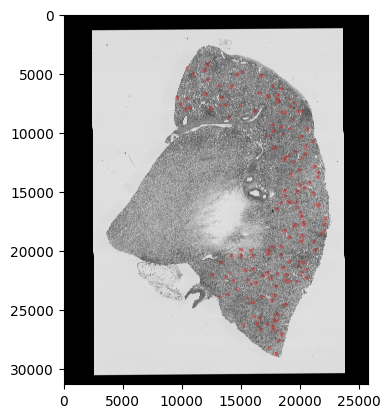

In [4]:
# Convert to numpy array
kidney_array = np.asarray(kidney_gray_im, dtype=np.float32)

# Load label path from json file
kidney_label = json.load(open(TEST_LABEL_PATH))
for element in kidney_label:
    if element['type'] == 'Feature' and element['id'] == 'PathAnnotationObject':
        label = element['geometry']
        if label['type'] == 'Polygon':
            coordinates = label['coordinates'][0]

            # Create polygon from label coordinates and plot
            label_polygon = Polygon(coordinates, closed=True, color='red', alpha=0.2)
            ax = plt.gca()
            ax.add_patch(label_polygon)

imgplot = plt.imshow(kidney_array, cmap='gray')

### Test running the model with pretrained weights from the paper's author

In [10]:
# Func for gettting models with different configs for quickly testing
def run_vit_model(model_name, model_path, n_classes, n_skip, patches_size, img_size, image):

    # Apply config for selected network
    config_vit = CONFIGS_ViT_seg[model_name]
    config_vit.n_classes = n_classes
    config_vit.n_skip = n_skip
    config_vit.patches.size = (patches_size, patches_size)
    if model_name.find('R50') !=-1:
            config_vit.patches.grid = (int(img_size/patches_size), int(img_size/patches_size))

    config_vit.pretrained_path = model_path
    net = ViT_seg(config_vit, img_size=img_size, num_classes=n_classes).cuda()

    # Load pretrained weights
    weights = np.load(model_path)
    net.load_from(weights=weights)

    # Run and convert output back to numpy array
    output = net.forward(image)
    output_array = output[0][0].cpu().detach().numpy()

    return output_array

### Section out a small block to try running it on the model

In [11]:
# Set where to take sample section from + section size
IMG_SIZE = 1024
X_SEEK = 15000
Y_SEEK = 15000

# Section out a sample image and format for inputting to model
test_block = torch.from_numpy(np.array([np.array([kidney_array[Y_SEEK:Y_SEEK+IMG_SIZE,X_SEEK:X_SEEK+IMG_SIZE]])]))
test_block = test_block.to(torch.device('cuda'))
test_block = test_block.type(torch.cuda.FloatTensor)
# Set where to take sample section from + section size

### List of available networks with pretrained from the paper
Example on github uses R50-ViT-B_16, get pretrained model files from [this link](https://console.cloud.google.com/storage/browser/vit_models/imagenet21k?pageState=(%22StorageObjectListTable%22:(%22f%22:%22%255B%255D%22))&prefix=&forceOnObjectsSortingFiltering=false)

In [20]:
# Available networks
vit_networks = [
    'ViT-B_16',
    'ViT-B_32',
    'ViT-L_16',
    'ViT-L_32',
    'ViT-H_14',
    'R50-ViT-B_16',
    'R50-ViT-L_16',
    'testing'
]

load_pretrained: grid-size from 14 to 64


Text(0.5, 1.0, 'Actual Image (Gray Scale)')

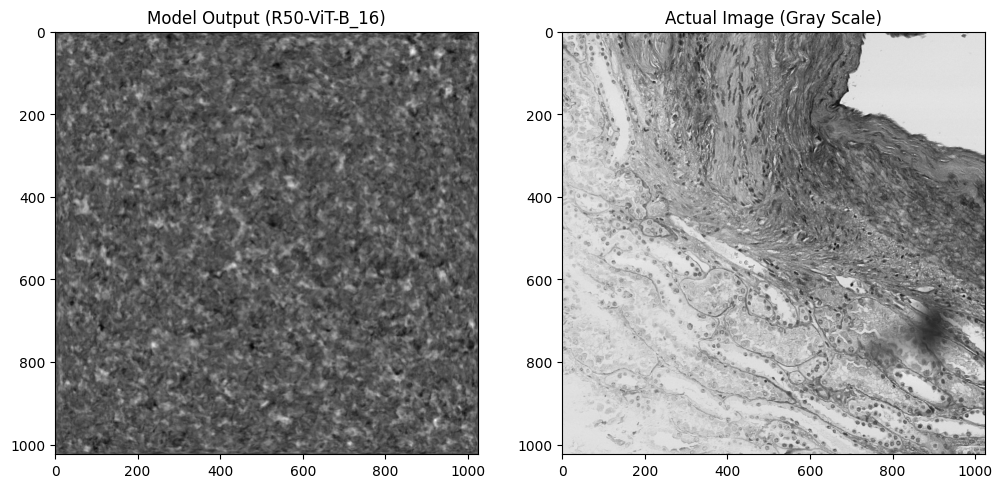

In [22]:
# Set which network to use + set pretrained weight path
VIT_MODEL = 'R50-ViT-B_16'
MODEL_PATH = './models/R50+ViT-B_16.npz'

output = run_vit_model(
    model_name = VIT_MODEL,
    model_path = MODEL_PATH,
    n_classes = 1,
    n_skip = 1,
    patches_size = 16,
    img_size = IMG_SIZE,
    image = test_block
)

# Plot model output vs actual image
f, axes = plt.subplots(1, 2, figsize=(12, 12))
axes[0].imshow(output, cmap='gray')
axes[0].set_title(f'Model Output ({VIT_MODEL})')
axes[1].imshow(kidney_array[Y_SEEK:Y_SEEK+IMG_SIZE,X_SEEK:X_SEEK+IMG_SIZE], cmap='gray')
axes[1].set_title('Actual Image (Gray Scale)')

## 4. Main Part

### Dataset Classes

In [6]:
# Kidney image class, store image arrays
# Configurable to get image samples as different patch sizes. Allow for accessing each samples as index
class KidneyImages(Dataset):
    def __init__(self, img_arrays, config):
        super().__init__()

        self.config = config
        if not isinstance(img_arrays, np.ndarray):
            self.img_arrays = np.array(img_arrays)
        else:
            self.img_arrays = img_arrays

        self.patches_size = config.patches_size
        self.stride = config.stride
        self.allow_padding = config.allow_padding

    # Get number of strides possible with the current dataset's patch_size and stride of an array array_len long
    def _get_num_strides(self, array_len):
        if self.allow_padding:
            return int(np.ceil((array_len - self.patches_size) / self.stride)) + 1
        else:
            return int(np.floor((array_len - self.patches_size) / self.stride)) + 1

    # Get number of strides possible with the current dataset's patch_size and stride of an image within the dataset
    def _get_img_strides(self, img_id, dim='2d'):
        num_strides_horizontal = self._get_num_strides(self.img_arrays[img_id].shape[1])
        num_strides_vertical = self._get_num_strides(self.img_arrays[img_id].shape[0])

        match dim:
            case '2d':
                return num_strides_horizontal * num_strides_vertical
            case 'horizontal':
                return num_strides_horizontal
            case 'vertical':
                return num_strides_vertical
            case _:
                raise ValueError('Unknown dimension config. Please choose from 2d, horizontal, or vertical')

    # Return number of sub samples that can be taken with current dataset's patch_size and stride
    def __len__(self):
        total_strides = 0
        for img_id in range(len(self.img_arrays)):
            total_strides += self._get_img_strides(img_id, dim='2d')
        return total_strides

    # Return patch from a specific image and patch index within the image
    def _get_patch(self, img_id, idx):
        num_strides_horizontal = self._get_img_strides(img_id, dim='horizontal')
        patch_idx_vertical = idx // num_strides_horizontal * self.stride
        patch_idx_horizontal = idx % num_strides_horizontal * self.stride

        img_height = self.img_arrays[img_id].shape[0]
        img_width = self.img_arrays[img_id].shape[1]

        if patch_idx_vertical >= img_height or patch_idx_horizontal >= img_width:
            raise IndexError(f'dataset index out of range, dataset length is {self.__len__()}')

        if not self.allow_padding:
            return self.img_arrays[img_id][
                patch_idx_vertical:patch_idx_vertical + self.patches_size,
                patch_idx_horizontal:patch_idx_horizontal + self.patches_size
            ]
        else:
            patch = self.img_arrays[img_id][
                patch_idx_vertical:min(img_height, patch_idx_vertical + self.patches_size),
                patch_idx_horizontal:min(img_width, patch_idx_horizontal + self.patches_size)
            ]

            pad_height = max(self.patches_size - patch.shape[0], 0)
            pad_width = max(self.patches_size - patch.shape[1], 0)

            padded_patch = np.pad(patch, ((0, pad_height), (0, pad_width)), mode='constant')

            return padded_patch

    # Return path from a patch index
    def __getitem__(self, idx):
        # Handle slicing, repeatedly call index version of the function
        if isinstance(idx, slice):
            return [self[ii] for ii in iter(range(*idx.indices(len(self))))]

        # Handle index
        elif isinstance(idx, int):
            current_idx = idx
            current_img_id = 0
            found_img_id = False
            for img_id in range(len(self.img_arrays)):
                current_num_strides = self._get_img_strides(img_id, dim='2d')
                if current_idx - current_num_strides < 0:
                    current_img_id = img_id
                    found_img_id = True
                    break
                else:
                    current_idx -= current_num_strides
            if not found_img_id:
                raise IndexError(f'dataset index out of range, dataset length is {self.__len__()}')
            return self._get_patch(current_img_id, current_idx)

    # Return list of image dimensions
    def get_dimensions(self):
        dimension_list = []
        for img_array in self.img_arrays:
            dimension_list.append(img_array.shape)
        return dimension_list

class KidneyLabels(KidneyImages):
    def __init__(self, label_jsons, img_sizes, config):
        # Parse each json labels and save as binary masks
        binary_masks = []
        for idx, label_json in enumerate(tqdm(label_jsons, desc='Parsing json files', total=len(label_jsons))):
            binary_masks.append(self._parse_label(label_json, img_sizes[idx], config.target_label))

        super().__init__(binary_masks, config)

        self.config = config

    # Parse label_json and returns a 0/1 mask
    def _parse_label(self, label_json, img_size, target_label):
        binary_mask = np.zeros(img_size, dtype=bool)
        pbar = tqdm(total=len(label_json), desc='Rendering mask')
        for element in label_json:
            if element['type'] == 'Feature' and element['id'] == 'PathAnnotationObject':
                label = element['geometry']
                if label['type'] == 'Polygon' and element['properties']['classification']['name'] == target_label:
                    # Get label polygon and render as binary mask
                    coordinates = label['coordinates'][0]
                    image = np.array(draw.polygon2mask(img_size,np.flip(coordinates, axis=None)), dtype=bool)

                    # Bitwise OR to add new labels in-place
                    np.bitwise_or(binary_mask, image, out=binary_mask)
            pbar.update(1)
        pbar.close()
        return binary_mask

# Main dataset class
class KidneyDataset(Dataset):
    def __init__(self, img_arrays, label_jsons, config):
        super().__init__()
        self.images = KidneyImages(img_arrays, config)
        img_sizes = self.images.get_dimensions()

        self.labels = KidneyLabels(label_jsons, img_sizes, config)

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        return self.images[idx], self.labels[idx]

### Loading Functions

In [132]:
import rasterio

# Generator for getting all the files in a dir with a specific file format
def get_folder_files(folder_dir, target_format):
    target_extension = target_format.strip('.')
    for file_name in os.listdir(folder_dir):
        file_format = file_name.split('.')[-1]
        if target_extension == file_format:
            yield os.path.join(folder_dir, file_name)

# Returns a pair of dataset image list and json label list.
# max_files are to limit number of files loaded due to system's RAM constrains. Decrease this if you encounter not enough memory error
def load_dataset_files(dir_path, max_files, config):
    img_paths = [path for path in get_folder_files(TRAIN_FOLDER_PATH, '.tiff')]
    label_paths = [path for path in get_folder_files(TRAIN_FOLDER_PATH, '.json')]

    # Remove the other json file without the glomerulus labels
    label_paths = [path for path in label_paths if not 'anatomical-structure' in path]

    # Sort path list so the filenames in both lists align
    img_paths.sort()
    label_paths.sort()

    # Limit number of files
    img_paths = img_paths[:max_files]
    label_paths = label_paths[:max_files]

    img_list = []
    label_list = []

    # Load image arrays to list
    for img_path in tqdm(img_paths, desc='Loading Images'):
        with rasterio.open(img_path) as image:
            img = image.read()

        # If config set to grayscale, convert img to grayscale
        if config.img_channels == 1:
            print(img.shape)
#             img = ImageOps.grayscale(img)

        img_array = np.asarray(img, dtype=np.float32)
        img_list.append(img_array)

    # Load json to list
    for label_path in tqdm(label_paths, desc='Loading Labels'):
        label = json.load(open(label_path))
        label_list.append(label)

    return img_list, label_list

SyntaxError: '(' was never closed (987336704.py, line 35)

### Dataset Configs

In [128]:
dataset_config = {
    'patches_size': 512,
    'stride': 512,
    'allow_padding': True,
    'target_label': 'glomerulus',
    'img_channels': 3   # Number of color channels, Grayscale = 1 / RGB = 3
}

dataset_config = ml_collections.ConfigDict(dataset_config)

TRAIN_FOLDER_PATH = './kidney_dataset/train'
MAX_FILES = 2


### Load Dataset (Takes a while to run, adjust MAX_FILES in cell above if you run out of RAM)

In [129]:
# export CV_IO_MAX_IMAGE_PIXELS=1099511627776
os.environ["OPENCV_IO_MAX_IMAGE_PIXELS"] = str(pow(2,40))
img_arrays, label_jsons = load_dataset_files(TRAIN_FOLDER_PATH, MAX_FILES, dataset_config)

Loading Images:   0%|          | 0/2 [00:00<?, ?it/s]

Loading Labels:   0%|          | 0/2 [00:00<?, ?it/s]

In [130]:
# Split and use last img as eval, should probably write save and load function for mask since it takes a rly long time to render
val_dataset = KidneyDataset(img_arrays[:MAX_FILES-1], label_jsons[:MAX_FILES-1], dataset_config)
train_dataset = KidneyDataset(img_arrays[MAX_FILES-1:], label_jsons[MAX_FILES-1:], dataset_config)

Parsing json files:   0%|          | 0/1 [00:00<?, ?it/s]

Rendering mask:   0%|          | 0/130 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [120]:
train_dataset.images.img_arrays[0]

array([[0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [110]:
# Total number of sample sections
print(f'Train: {len(train_dataset.images)}')
print(f'Val: {len(val_dataset.images)}')

Train: 75
Val: 51


In [111]:
# Free up memory|
import gc
gc.collect()
torch.cuda.empty_cache()

### Display Sample Images

IndexError: list index out of range

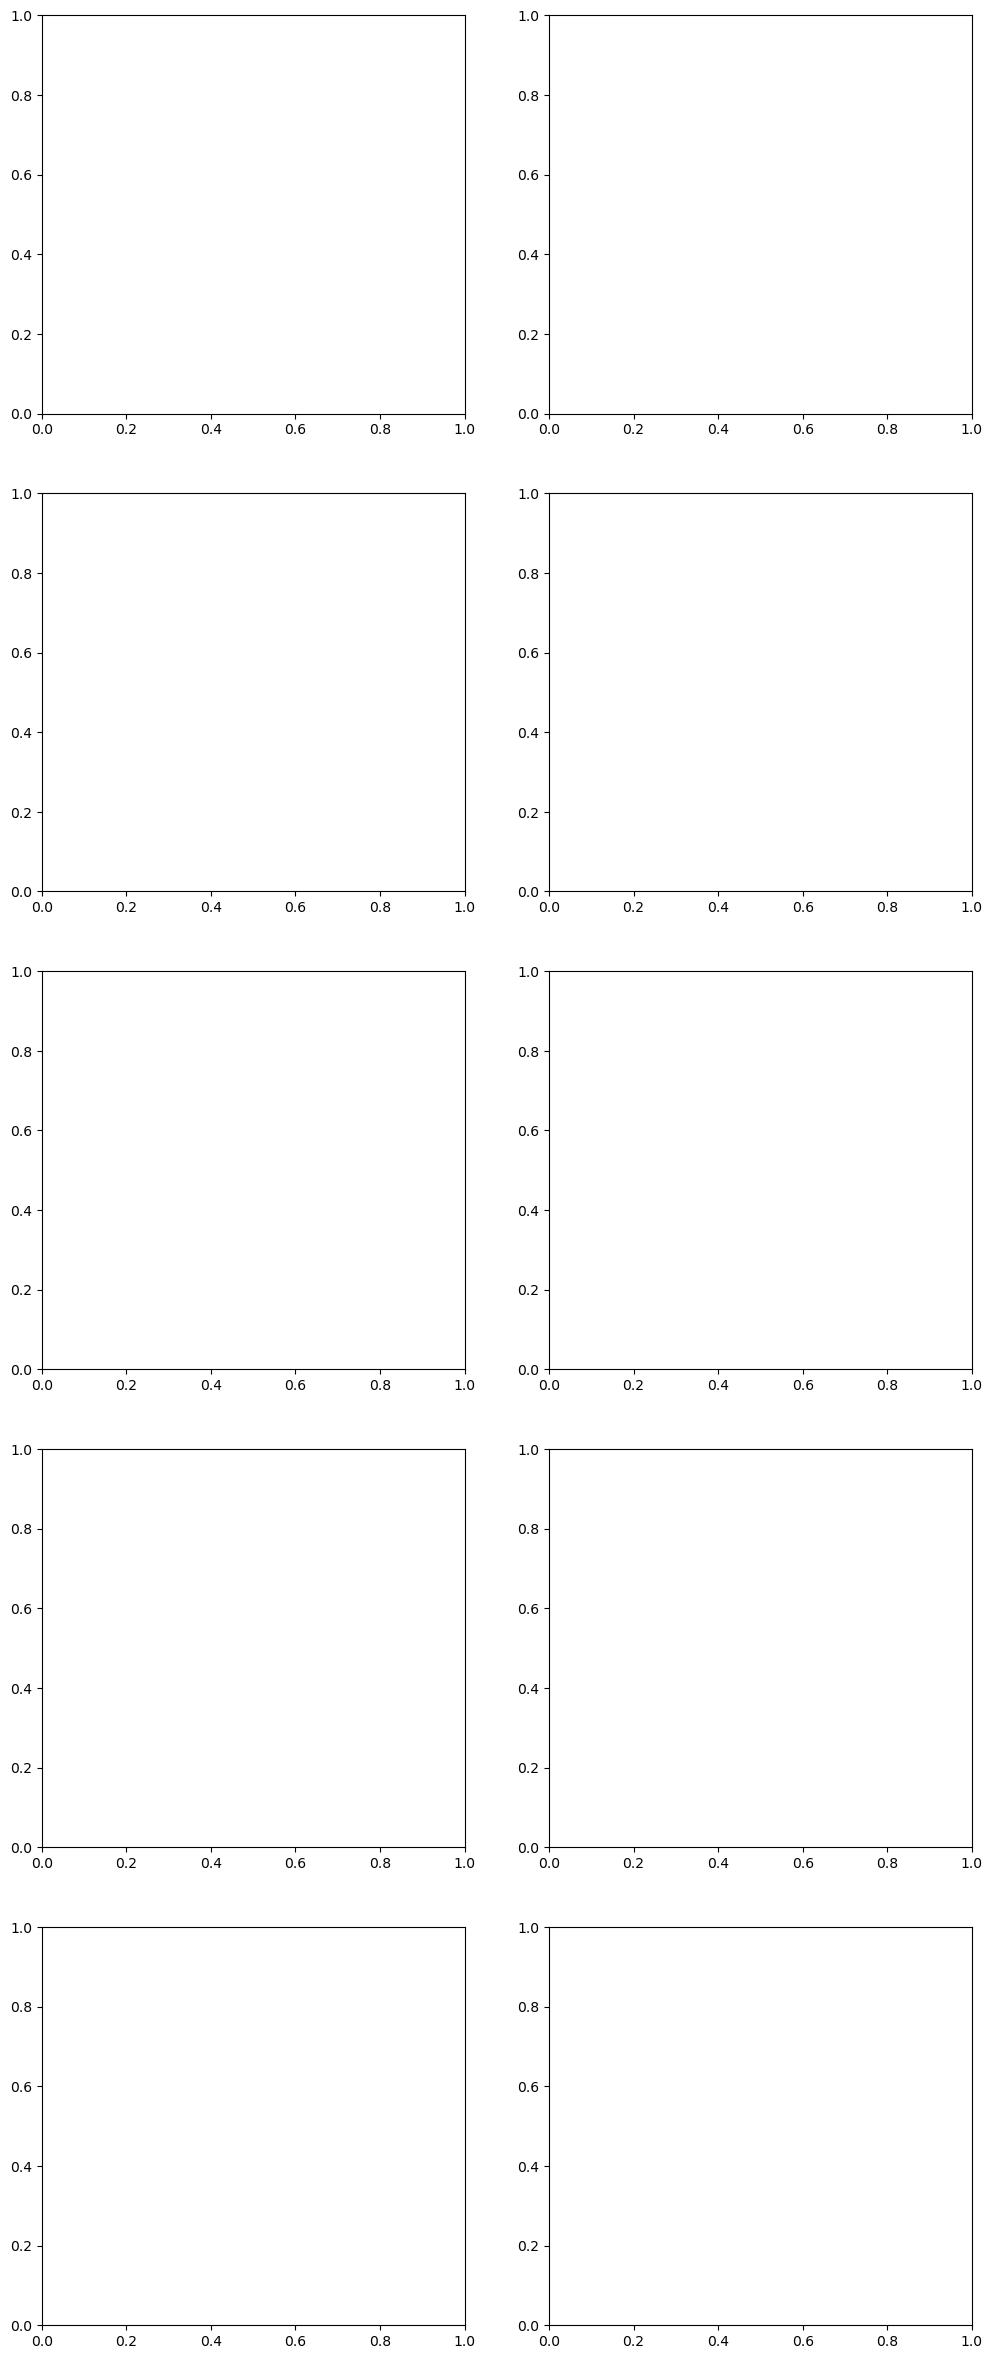

In [116]:
# Search for indices with glomeruli
glomeruli_indices = []
for idx, label in enumerate(train_dataset.labels):
    if label.any() == True:
        glomeruli_indices.append(idx)

# Plot
NUM_PLOTS = 5
f, axes = plt.subplots(5, 2, figsize=(12, 30))
for idx in range(NUM_PLOTS):
    axes[idx][0].imshow(train_dataset.images[glomeruli_indices[idx]], cmap='gray')
    axes[idx][1].imshow(train_dataset.labels[glomeruli_indices[idx]], cmap='gray')
axes[0][0].set_title('Grayscale Image')
axes[0][1].set_title('Glomeruli Label')

f.tight_layout()

In [129]:
train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=2, shuffle=True)

In [130]:
# Set which network to use + set pretrained weight path
VIT_MODEL = 'R50-ViT-B_16'
MODEL_PATH = './models/R50+ViT-B_16.npz'

### Train
Rough training function to test if training the model works or not

In [145]:
# Barebones training
def train(config, model_name=VIT_MODEL, model_path=MODEL_PATH, n_classes=1, n_skip=1, patches_size=16, epochs=100):
    # Apply config for selected network
    config_vit = CONFIGS_ViT_seg[model_name]
    config_vit.n_classes = n_classes
    config_vit.n_skip = n_skip
    config_vit.patches.size = (patches_size, patches_size)
    if model_name.find('R50') !=-1:
        config_vit.patches.grid = (int(config.patches_size/patches_size), int(config.patches_size/patches_size))

    gc.collect()
    torch.cuda.empty_cache()
    config_vit.pretrained_path = model_path
    model = ViT_seg(config_vit, img_size=config.patches_size, num_classes=n_classes).cuda()

    # Load pretrained weights
    weights = np.load(model_path)
    model.load_from(weights=weights)

    train_loss = []
    val_loss = []

    ce_loss = CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0001)
    pbar = tqdm(total=epochs, desc='Epoch')
    for epoch in range(epochs):
        # Train
        model.train()
        running_loss = 0
        for inputs, labels in tqdm(train_dataloader, desc='Train'):
            gc.collect()
            torch.cuda.empty_cache()
            # Move data to GPU
            inputs = inputs.unsqueeze(1).cuda()
            labels = labels.unsqueeze(1).cuda()
            # Run model
            outputs = model.forward(inputs)

            loss = ce_loss(outputs, labels[:].type(torch.cuda.FloatTensor))
            optimizer.zero_grad()
            loss.backward()
            running_loss += loss.item()
            optimizer.step()

        train_epoch_loss = running_loss / len(train_dataloader)
        train_loss.append(train_epoch_loss)

        # Val
        model.eval()
        running_loss = 0
        with torch.no_grad():
            for inputs, labels in tqdm(val_dataloader, desc='Val'):
                gc.collect()
                torch.cuda.empty_cache()
                # Move data to GPU
                inputs = inputs.unsqueeze(1).cuda()
                labels = labels.unsqueeze(1).cuda()
                # Run model
                outputs = model.forward(inputs)

                loss = ce_loss(outputs, labels[:].type(torch.cuda.FloatTensor))
                running_loss += loss.item()
        val_epoch_loss = running_loss / len(val_dataloader)
        val_loss.append(val_epoch_loss)

        pbar.set_postfix({'Train Loss': train_epoch_loss, 'Val Loss': val_epoch_loss})
        pbar.update(1)

    torch.save(model.state_dict(), 'trained_model.npz')
    return train_loss, eval_loss


In [146]:
train_loss, eval_loss = train(dataset_config)


load_pretrained: grid-size from 14 to 32


Epoch:   0%|          | 0/100 [00:00<?, ?it/s]

Train:   0%|          | 0/4647 [00:00<?, ?it/s]

IndexError: ignored

## Data Exploration

In [15]:
import torch.nn as nn
# List of available pretrained resnets from pytorch
class Pretrains():
    resnet_versions = [
        'resnet18',
        'resnet34',
        'resnet50',
        'resnet101',
        'resnet152'
    ]
    vgg_versions = [
        'vgg11',
        'vgg11_bn',
        'vgg13',
        'vgg13_bn',
        'vgg16',
        'vgg16_bn',
        'vgg19',
        'vgg19_bn'
    ]

class PretrainBackbone(nn.Module):
    def __init__(self, config):
        super(ResNetBackbone, self).__init__()
        
        # Load pretrained ResNet/VGG backbone
        if config.pretrain in Pretrains.resnet_versions or config.resnet_version in Pretrains.vgg_versions:
            model = torch.hub.load('pytorch/vision:v0.10.0', config.pretrain, pretrained=True)
        else:
            raise ValueError('Invalid ResNet/VGG Version. Please select from: ' 
                             + ', '.join(Pretrains.resnet_versions + Pretrains.vgg_versions))
        
        # Segments out only the backbone layers as list, unpacks, and load into nn.Sequential
        backbone_layers = list(model.children())[:-1]
        self.backbone = nn.Sequential(*backbone_layers)
        
    def forward(self, x):
        x = self.backbone(x)
        return x

class ActivationFunction(nn.Module):
    def __init__(self, config):
        super(ActivationFunction, self).__init__()
        match config.type:
            case 'LeakyReLU':
                self.activation_func = nn.LeakyReLU(
                    config.negative_slope,
                    inplace = True
                )
            case 'ReLU':
                self.activation_func = nn.ReLU(inplace = True)
            case 'Softmax':
                self.activation_func = nn.Softmax(dim = self.dim)
            case _:
                raise ValueError('Invalid activation function or not implemented')
    def forward(self, x):
        return self.activation_func(x)

class Conv2dBlock(nn.Module):
    def __init__(self, config):
        super(Conv2dBlock, self).__init__()
        modules = []
        if config.layer_num < 1:
            raise ValueError('Number of layers cannot be less than 1')
        for layer_idx in range(config.layer_num):
            # Conv2d
            modules.append(nn.Conv2d(
                config.in_channels if not layer_idx else config.out_channels,
                config.out_channels,
                kernel_size = 3,
                padding = 1
            ))
            
            # Batch Normalization
            if config.use_batchnorm:
                modules.append(nn.BatchNorm2d(config.out_channels))
                
            # Activation function, skip this step if skip_last_activation is True
            if config.skip_last_activation and layer_idx == config.layer_num - 1:
                break   
            modules.append(ActivationFunction(config.activation_func))
        self.sequential = nn.Sequential(*modules)
        
    def forward(self, x):
        return self.sequential(x)

# Creates a mirrored Conv2dBlock
class RevConv2dBlock(nn.Module):
    def __init__(self, conv2d_block):
        super(RevConv2dBlock, self).__init__()
        
        # Reverses module from conv2d_block
        modules = list(conv2d_block.sequential)
        modules.reverse()
        module_iterator = iter(range(len(modules)))
        for idx in module_iterator:
            if isinstance(modules[idx], torch.nn.modules.batchnorm.BatchNorm2d):
                
                # Switch order of batch and conv2d
                modules[idx], modules[idx + 1] = modules[idx + 1], modules[idx]
                
                # Swap conv2d with convtranspose2d
                modules[idx] = nn.ConvTranspose2d(
                    modules[idx].out_channels,
                    modules[idx].in_channels,
                    kernel_size = modules[idx].kernel_size,
                    stride = modules[idx].stride,
                    padding = modules[idx].padding
                )
                
                modules[idx + 1] = nn.BatchNorm2d(modules[idx].out_channels)
                
                # Skip next index
                next(module_iterator)
            
        if isinstance(modules[0], ActivationFunction):
            activation_func = modules.pop(0)
            modules.append(activation_func)
            
        self.sequential = nn.Sequential(*modules)
        
    def forward(self, x):
        return self.sequential(x)
    
class VGGBackboneBlock(nn.Module):
    def __init__(self, config):
        super(VGGBackboneBlock, self).__init__()
        config.skip_last_activation = False
        
        # Conv2d
        self.conv2d_block = Conv2dBlock(config)
        
        # Maxpool
        self.maxpool = nn.MaxPool2d(
            kernel_size=config.compression_ratio, 
            stride=config.compression_ratio
        )
    
    def forward(self, x):
        out = self.conv2d_block(x)
        out = self.maxpool(out)
        return out
    
    def get_reverse(self):
        return RevVGGBackconeBlock(self)
    
class RevVGGBackconeBlock(nn.Module):
    def __init__(self, vgg_backbone_block):
        super(VGGBackboneBlock).__init__()
        # To be implemented
    def forward(self, x):
        # To be implemented
        return x
    
class ResidualBlock(nn.Module):
    def __init__(self, config):
        super(ResidualBlock, self).__init__()
        
        # Main Conv2d block
        main_block_config = config
        main_block_config.layer_num = config.main_layer_num
        main_block_config.skip_last_activation = True
        self.main_block = Conv2dBlock(main_block_config)
        
        # Shortcut Conv2d block, we leave self.shortcut_block as undefined if shortcut layer depth = 0
        if config.shortcut_layer_num:
            shortcut_block_config = config
            shortcut_block_config.layer_num = config.shortcut_layer_num
            shortcut_block_config.skip_last_activation = True
            self.shortcut_block = Conv2dBlock(shortcut_block_config)
            
        self.activation_func = ActivationFunction(config.activation_func)
        
        # Optional maxpooling layer if compression_ratio is set
        if hasattr(config, 'compression_ratio'):
            self.maxpool = nn.MaxPool2d(
                kernel_size=config.compression_ratio, 
                stride=config.compression_ratio
        )
    
    def forward(self, x):
        out = self.main_block(x)
        if hasattr(self, 'shortcut_block'):
            out += self.shortcut_block(x)
        else:
            out += x
            
        out = self.activation_func(out)
            
        if hasattr(self, 'maxpool'):
            out = self.maxpool(out)
            
        return out

    def get_reverse(self):
        # Get reversed version
        return RevResidualBlock(self)

class RevResidualBlock(nn.Module):
    def __init__(self, residual_block):
        super(RevResidualBlock, self).__init__()
        self.main_block = RevConv2dBlock(residual_block.main_block)
        
        if hasattr(residual_block, 'shortcut_block'):
            self.shortcut_block = RevConv2dBlock(residual_block.shortcut_block)
            
        if hasattr(residual_block, 'maxpool'):
            self.upsample = nn.Upsample(scale_factor=residual_block.maxpool.stride)
            
    def forward(self, x):
        if hasattr(self, 'upsample'):
            x = self.upsample(x)
        else:
            x = x
            
        out = self.main_block(x)
        
        if hasattr(self, 'shortcut_block'):
            out += self.shortcut_block(x)
        else:
            out += x
        return out
    
class Encoder(nn.Module):
    def __init__(self, config):
        super(Encoder, self).__init__()
        modules = []
        match config.type:
            case 'residual_blocks':
                for idx, block_feature in enumerate(config.features):
                    if not idx:
                        in_channels = config.in_channels
                        out_channels = block_feature
                    else:
                        in_channels = config.features[idx - 1]
                        out_channels = block_feature

                    block_config = ml_collections.ConfigDict({
                        'main_layer_num': config.main_layer_num,
                        'shortcut_layer_num': config.shortcut_layer_num,
                        'in_channels': in_channels,
                        'out_channels': out_channels,
                        'use_batchnorm': config.use_batchnorm,
                        'activation_func': config.activation_func,
                    })
                    if hasattr(config, 'compression_ratio'):
                        block_config.compression_ratio = config.compression_ratio

                    modules.append(ResidualBlock(block_config))
            case 'vgg_backbone_blocks':
                # To be implemented
                raise NotImplementedError('To be implemented')
                
        self.sequential = nn.Sequential(*modules)
    def forward(self, x):
        return self.sequential(x)
        
class Decoder(nn.Module):
    def __init__(self, arg):
        super(Decoder, self).__init__()
        # Initialize by mirroring encoder
        if isinstance(arg, Encoder):
            encoder = arg
            modules = list(encoder.sequential)
            modules.reverse()
            
            for idx in range(len(modules)):
                modules[idx] = modules[idx].get_reverse()
            self.sequential = nn.Sequential(*modules)
        # Initialize by config (not implemented since we are using mirrored encoder/decoder)
        else:
            raise NotImplementedError('This decoder class is only implemented to be initialized by mirroring an encoder class')
    def forward(self, x):
        return self.sequential(x)
    
class AutoEncoder(nn.Module):
    def __init__(self, config):
        super(AutoEncoder, self).__init__()
        # Encoder
        encoder_config = config.encoder_config
        encoder_config.in_channels = config.in_channels
        self.encoder = Encoder(encoder_config)
        
        # Check for bottleneck input size by passing dummy input to encoder
        dummy_input = torch.randn(1, config.in_channels, config.in_dimension[0], config.in_dimension[1])
        out = self.encoder.forward(dummy_input)
        out_dimension = list(out.size())
        in_bottleneck = out_dimension[1] * out_dimension[2] * out_dimension[3]
        
        # Bottleneck
        self.bottleneck = nn.Linear(in_bottleneck, config.bottleneck_width)
        
        # Bottleneck output reshaper
        self.decoder_in_shape = out_dimension
        self.bottleneck_reshape = nn.Conv2d(config.bottleneck_width, out_dimension[1], kernel_size=1)
        
        # Decoder
        self.decoder = Decoder(self.encoder)
        
    def forward(self, x):
        # Encoder
        out = self.encoder(x)
        
        # Reshape to fit bottleneck
        encoder_out_shape = out.size() 
        flatten = out.view(out.size(0), -1)
        
        # Bottleneck
        out = self.bottleneck(flatten)
        
        # Reshape to fit decoder
        out_reshaped = out.view(out.size()[0], out.size()[1], 1, 1)
        out = self.bottleneck_reshape(out_reshaped)
        out = nn.AdaptiveAvgPool2d((self.decoder_in_shape[2], self.decoder_in_shape[3]))(out)
        
        # Decoder
        out = self.decoder(out)
        
        return out

In [19]:
dimension = 512
dtype = torch.cuda.FloatTensor
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [20]:
config_dict = {
    'in_dimension': (dimension, dimension),
    'in_channels': 3,
    'encoder_config': {
        'type': 'residual_blocks',
        'compression_ratio': 2,
        'features': [64, 128, 256, 512, 512, 512],
        'main_layer_num': 3,
        'shortcut_layer_num': 1,
        'use_batchnorm': True,
        'activation_func': {
            'type': 'LeakyReLU',
            'negative_slope': 0.1
        },
    },
    'decoder_config': {
        'mirror_encoder': True
    },
    'bottleneck_width': 256
}


test_config = ml_collections.ConfigDict(config_dict)

autoencoder = AutoEncoder(test_config).cuda()
autoencoder.forward(torch.randn(1, 3, 512, 512).type(dtype)).size()

torch.Size([1, 3, 512, 512])

In [23]:
import gc
def train_autoencoder(model, epochs=100):
    gc.collect()
    torch.cuda.empty_cache()

    # Load pretrained weights

    train_loss = []
    val_loss = []

    ce_loss = CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0001)
    pbar = tqdm(total=epochs, desc='Epoch')
    for epoch in range(epochs):
        # Train
        model.train()
        running_loss = 0
        for inputs, labels in tqdm(train_dataloader, desc='Train'):
            gc.collect()
            torch.cuda.empty_cache()
            # Move data to GPU
            inputs = inputs.unsqueeze(1).cuda()
            labels = labels.unsqueeze(1).cuda()
            # Run model
            outputs = model.forward(inputs)

            loss = ce_loss(outputs, labels[:].type(torch.cuda.FloatTensor))
            optimizer.zero_grad()
            loss.backward()
            running_loss += loss.item()
            optimizer.step()

        train_epoch_loss = running_loss / len(train_dataloader)
        train_loss.append(train_epoch_loss)

        # Val
        model.eval()
        running_loss = 0
        with torch.no_grad():
            for inputs, labels in tqdm(val_dataloader, desc='Val'):
                gc.collect()
                torch.cuda.empty_cache()
                # Move data to GPU
                inputs = inputs.unsqueeze(1).cuda()
                labels = labels.unsqueeze(1).cuda()
                # Run model
                outputs = model.forward(inputs)

                loss = ce_loss(outputs, labels[:].type(torch.cuda.FloatTensor))
                running_loss += loss.item()
        val_epoch_loss = running_loss / len(val_dataloader)
        val_loss.append(val_epoch_loss)

        pbar.set_postfix({'Train Loss': train_epoch_loss, 'Val Loss': val_epoch_loss})
        pbar.update(1)

    torch.save(model.state_dict(), 'trained_model.npz')
    return train_loss, eval_loss
train_autoencoder(autoencoder)

Epoch:   0%|          | 0/100 [00:00<?, ?it/s]

NameError: name 'train_dataloader' is not defined